<a href="https://colab.research.google.com/github/rafaelnordavind/artigo-final/blob/main/01_Artigo_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Artigo: Versão final

Nome: Rafael Luiz Xavier

## 1. Introdução

O trabalho envolve a previsão de carga de trabalho (quantidade de requisições por segundo) de usuários em um serviço web. A previsão da carga de trabalho pode permitir a criação de políticas de escalonamento de serviços para atender com qualidade a demanda minimizando o uso de recursos computacionais e por consequencia de energia. As políticas de redimensionamento automática podem reduzir o trabalho manual das equipes de operações em dias de grande demanda pelos usuários através da criação de um sistema autonômico que operacionaliza o escalonamento de instâncias das aplicações.

A previsão da carga de trabalho poderá ser aplicada na auto escala de serviços web legados de inscrição e divulgação de resultados do vestibular da instituição, que geralmente é superdimensionado em dias normais e quando há um evento de inscrição (por exemplo, último dia de inscrição) ou de divulgação de resultados, os serviços costumam se degradar com a alta taxa de acessos pelos usuários.


### 1.1 Análise Exploratória dos Dados

### Base de dados (Clarknet Traces)
A base de dados coletada diretamente a partir dos serviços alvo não possui uma grande quantidade de dados, portanto foi escolhida uma base de dados de benchmarking que vem sendo utilizada em diversos trabalhos sobre o tema (Auto escala de serviços)

A base escolhida contêm duas semanas de todas as solicitações HTTP para o servidor www do ClarkNet. ClarkNet é um provedor de acesso completo à Internet para a área metropolitana de Baltimore-Washington DC.
Disponível em: https://ita.ee.lbl.gov/html/contrib/ClarkNet-HTTP.html

#### Importação das bibliotecas utilizadas

In [ ]:
# Importando as bibliotecas utilizadas
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import re
import os

import pandas as pd
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss



In [ ]:
# Baixando a base de dados do repositório do github
!mkdir dataset
!wget --no-check-certificate --no-parent -r \
"https://github.com/rafaelnordavind/artigo-final/blob/6e31c2a08322e9623eea3eb1b277492db2db02f1/dataset/access_1_utf800" \
-O "dataset/access_1_utf800"
!wget --no-check-certificate --no-parent -r \
"https://github.com/rafaelnordavind/artigo-final/blob/6e31c2a08322e9623eea3eb1b277492db2db02f1/dataset/access_1_utf801" \
-O "dataset/access_1_utf801"
!wget --no-check-certificate --no-parent -r \
"https://github.com/rafaelnordavind/artigo-final/blob/6e31c2a08322e9623eea3eb1b277492db2db02f1/dataset/access_1_utf802" \
-O "dataset/access_1_utf802"
!wget --no-check-certificate --no-parent -r \
"https://github.com/rafaelnordavind/artigo-final/blob/6e31c2a08322e9623eea3eb1b277492db2db02f1/dataset/access_1_utf803" \
-O "dataset/access_1_utf803"

mkdir: cannot create directory ‘dataset’: File exists
will be placed in the single file you specified.

--2023-06-26 06:30:15--  https://github.com/rafaelnordavind/artigo-final/blob/6e31c2a08322e9623eea3eb1b277492db2db02f1/dataset/access_1_utf800
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘dataset/access_1_utf800’

dataset/access_1_ut     [ <=>                ] 138.85K  --.-KB/s    in 0.08s   

2023-06-26 06:30:16 (1.75 MB/s) - ‘dataset/access_1_utf800’ saved [142186]

Loading robots.txt; please ignore errors.
--2023-06-26 06:30:16--  https://github.com/robots.txt
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 1508 (1.5K) [text/plain]
Saving to: ‘dataset/access_1_utf800’

dataset/access_1_ut 100%[===================>]   1.47K  --.-KB/s    in 0s      

2023-06-26 06:30

#### Processamento de texto (arquivo de log do servidor web Apache2) para geração do dataframe

In [ ]:
# Verificar se o arquivo clarknet_requests_data.csv existe
if not os.path.isfile('clarknet_requests_data.csv'):

    # Lista de nomes de arquivo
    dataset_files = ["dataset/access_1_utf800", "dataset/access_1_utf801", "dataset/access_1_utf802", "dataset/access_1_utf803"]

    # Cria uma lista para armazenar os dados lidos do arquivo de log
    log_data = []

    for file_name in dataset_files:


        # Define a expressão regular para extrair os campos do log do Apache
        apache_log_regex = r'^(\S+) (\S+) (\S+) \[(.*?)\] "(.*?)" (\d+) (\d+|-)$'

        # Abre o arquivo de texto e lê as linhas
        with open(file_name, 'r') as f:
            for line in f:
                # Faz o parsing dos campos da linha usando a expressão regular
                match = re.match(apache_log_regex, line)
                if match is not None:
                    # Extrai os campos da linha
                    host, _, _, timestamp, request, status, size = match.groups()
                    # Adiciona os campos a um dicionário
                    log_data.append({
                        'host': host,
                        'timestamp': timestamp,
                        'request': request,
                        'status': int(status),
                        'size': int(size) if size != '-' else 0
                    })

    # Cria um dataframe pandas com os dados lidos do arquivo de log
    clarknet_data = pd.DataFrame(log_data)
    # Salva o DataFrame em um arquivo CSV
    clarknet_data.to_csv('clarknet_requests_data.csv')
else:
    # Carrega o DataFrame a partir do arquivo CSV
    clarknet_data = pd.read_csv('clarknet_requests_data.csv', index_col=0)

# Converte a coluna timestamp para o formato datetime
clarknet_data['timestamp'] = pd.to_datetime(clarknet_data['timestamp'], format='%d/%b/%Y:%H:%M:%S %z')

# Imprimindo as primeiras linhas do dataframe
clarknet_data.head()

,host,timestamp,request,status,size
0,204.249.225.59,1995-08-28 00:00:34-04:00,GET /pub/rmharris/catalogs/dawsocat/intro.html...,200,3542
1,access9.accsyst.com,1995-08-28 00:00:35-04:00,GET /pub/robert/past99.gif HTTP/1.0,200,4993
2,access9.accsyst.com,1995-08-28 00:00:35-04:00,GET /pub/robert/curr99.gif HTTP/1.0,200,5836
3,world.std.com,1995-08-28 00:00:36-04:00,GET /pub/atomicbk/catalog/sleazbk.html HTTP/1.0,200,18338
4,cssu24.cs.ust.hk,1995-08-28 00:00:36-04:00,GET /pub/job/vk/view17.jpg HTTP/1.0,200,5944


#### Manipulando a base de dados inicial e gerando a base com quantidade de requisições por determinado período

##### Período: segundos

In [ ]:
# Verificar se o arquivo df_req_count.csv existe
if not os.path.isfile('df_req_count.csv'):
    # Agrupa as requisições por segundo e conta a quantidade de requisições em cada segundo
    req_count = clarknet_data.groupby(pd.Grouper(key='timestamp', freq='S')).size()

    # Cria um dataframe a partir do resultado da contagem de requisiçõess
    df_req_count = req_count.reset_index().rename(columns={0: 'num_requests'})

    # Salvando em um arquivo externo
    df_req_count.to_csv('df_req_count.csv')

else:
    # Carrega o DataFrame a partir do arquivo CSV
    df_req_count = pd.read_csv('df_req_count.csv')

# Converte a coluna timestamp para o formato datetime
df_req_count['timestamp'] = pd.to_datetime(df_req_count['timestamp'])

# Setando a coluna timestamp como indice
df_req_count.set_index('timestamp', inplace=True)

# Imprimindo as primeiras linhas do dataframe
df_req_count.head()


,num_requests
timestamp,
1995-08-28 00:00:34-04:00,1
1995-08-28 00:00:35-04:00,2
1995-08-28 00:00:36-04:00,2
1995-08-28 00:00:37-04:00,2
1995-08-28 00:00:38-04:00,4


##### Período: minutos

In [ ]:
# Agrupa as requisições por minuto e calcula o máximo em cada minuto
max_requests_min = df_req_count.groupby(pd.Grouper(level='timestamp', freq='min')).sum()
# Salvando em um arquivo externo
max_requests_min.to_csv('df_max_requests_min.csv')
max_requests_min.head()


,num_requests
timestamp,
1995-08-28 00:00:00-04:00,44
1995-08-28 00:01:00-04:00,124
1995-08-28 00:02:00-04:00,166
1995-08-28 00:03:00-04:00,117
1995-08-28 00:04:00-04:00,182


##### Período: 10 minutos

Período utilizado no artigo [1] Singh, P., Gupta, P. & Jyoti, 2019


In [ ]:
# Agrupa as requisições a cada 10 minutos e calcula o máximo em cada período
max_requests_10min = df_req_count.groupby(pd.Grouper(level='timestamp', freq='10T')).sum()
# Salvando em um arquivo externo
max_requests_10min.to_csv('df_max_requests_10min.csv')
max_requests_10min.head()

,num_requests
timestamp,
1995-08-28 00:00:00-04:00,1493
1995-08-28 00:10:00-04:00,1543
1995-08-28 00:20:00-04:00,1265
1995-08-28 00:30:00-04:00,1116
1995-08-28 00:40:00-04:00,1567


##### Período: Horas

In [ ]:
# Agrupa as requisições por hora e calcula o máximo em cada hora (para melhorar a visualização dos gráficos)
max_requests_hour = df_req_count.groupby(pd.Grouper(level='timestamp', freq='H')).max()

# Salvando em um arquivo externo
max_requests_hour.to_csv('df_max_requests_hour.csv')
max_requests_hour.head()

,num_requests
timestamp,
1995-08-28 00:00:00-04:00,15
1995-08-28 01:00:00-04:00,19
1995-08-28 02:00:00-04:00,9
1995-08-28 03:00:00-04:00,10
1995-08-28 04:00:00-04:00,12


##### Verificando o tamanho dos dataframes

## Análise da série temporal
### Plotagem da base de dados de benchmark Clarknet

A plotagem da base envolveu a contagem de requisições que foram realizadas em um mesmo segundo, outra linha com o valor máximo de requisições que ocorreram num intevalo de um minuto, outra com 10 minutos e outra com intervalo de 1 hora.

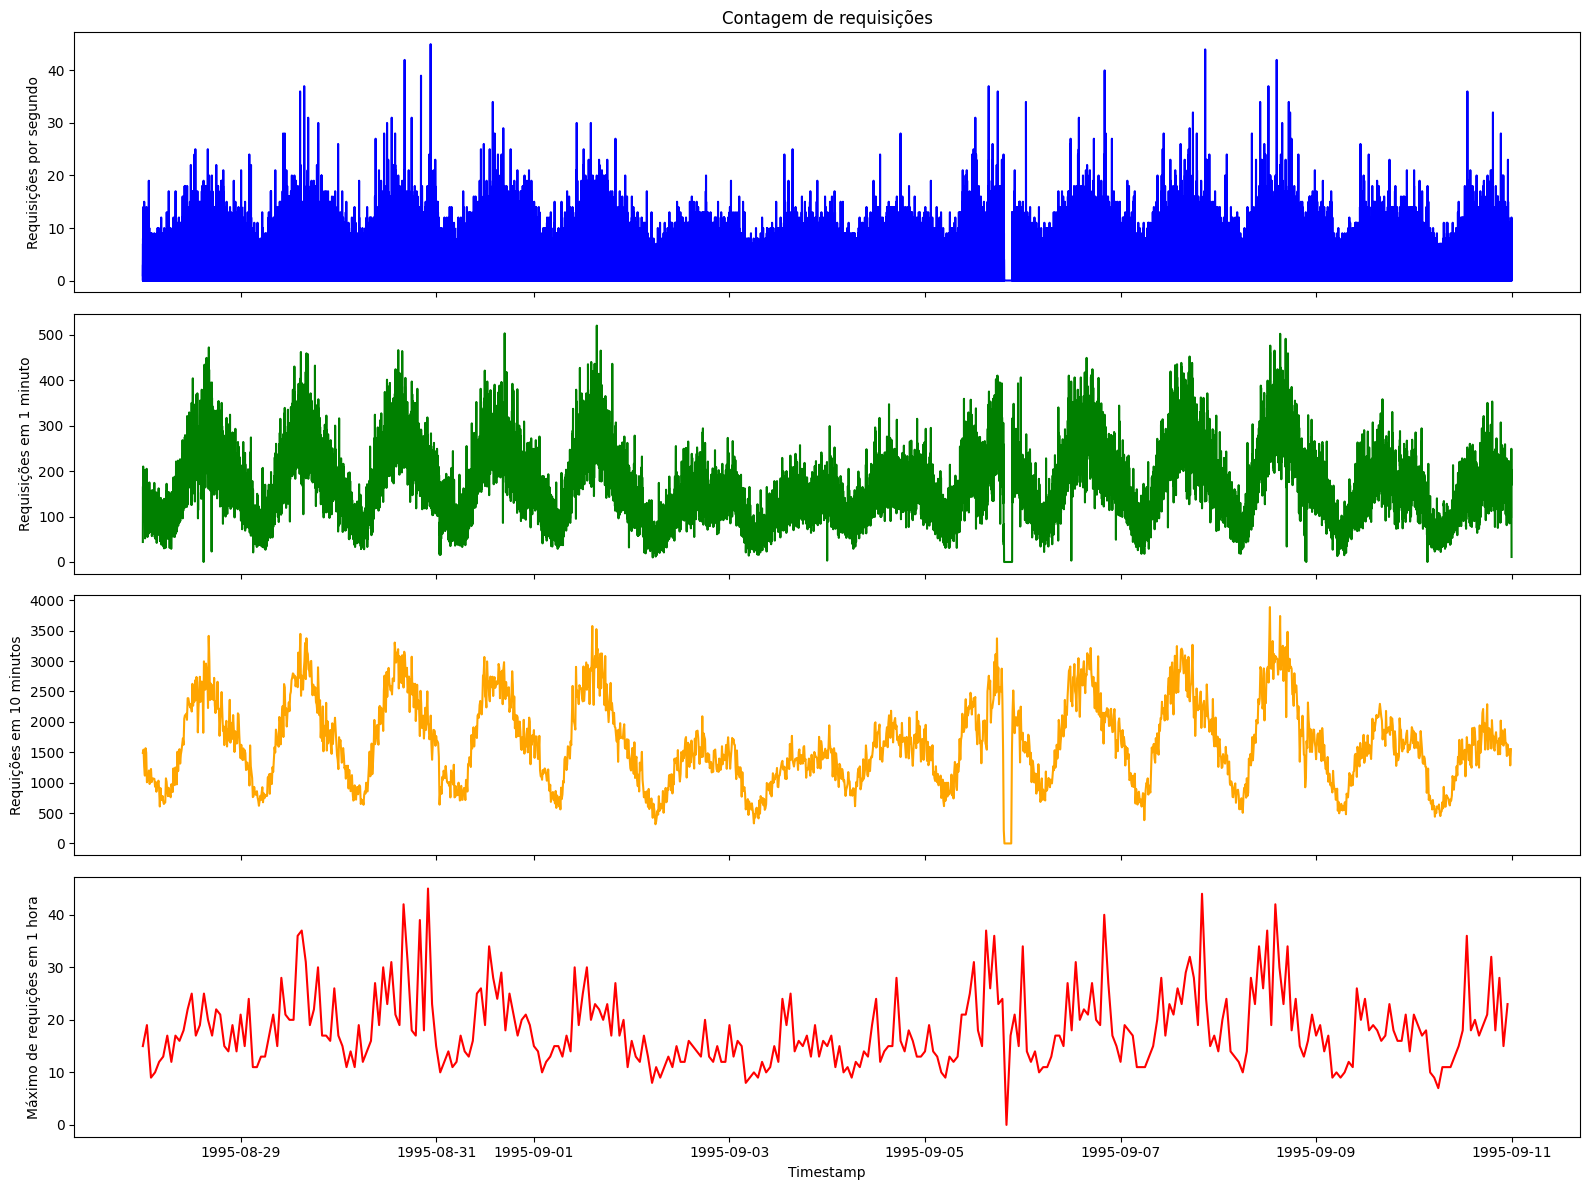

In [ ]:
# Cria uma figura com subplots
fig, axes = plt.subplots(4, 1, figsize=(16, 12), sharex=True)

# Primeiro subplot: Requisições por segundo
axes[0].plot(df_req_count.index, df_req_count['num_requests'], color='blue')
axes[0].set_ylabel('Requisições por segundo')
axes[0].set_title('Contagem de requisições')

# Segundo subplot: Máximo de requisições em 1 minuto
axes[1].plot(max_requests_min.index, max_requests_min.values, color='green')
axes[1].set_ylabel('Requisições em 1 minuto')

# Terceiro subplot: Máximo de requisições em 10 minutos
axes[2].plot(max_requests_10min.index, max_requests_10min.values, color='orange')
axes[2].set_ylabel('Requições em 10 minutos')

# Quarto subplot: Máximo de requisições em 1 hora
axes[3].plot(max_requests_hour.index, max_requests_hour.values, color='red')
axes[3].set_ylabel('Máximo de requições em 1 hora')
axes[3].set_xlabel('Timestamp')

# Ajusta o espaçamento entre os subplots
plt.tight_layout()

# Exibe o gráfico

#### Distribuição

Como a contagem de requisições são distribuídas em um determinado dia ou horário. Considerada para esta análise a serie que considera o valor máximo ocorrido no intervalo de uma hora.

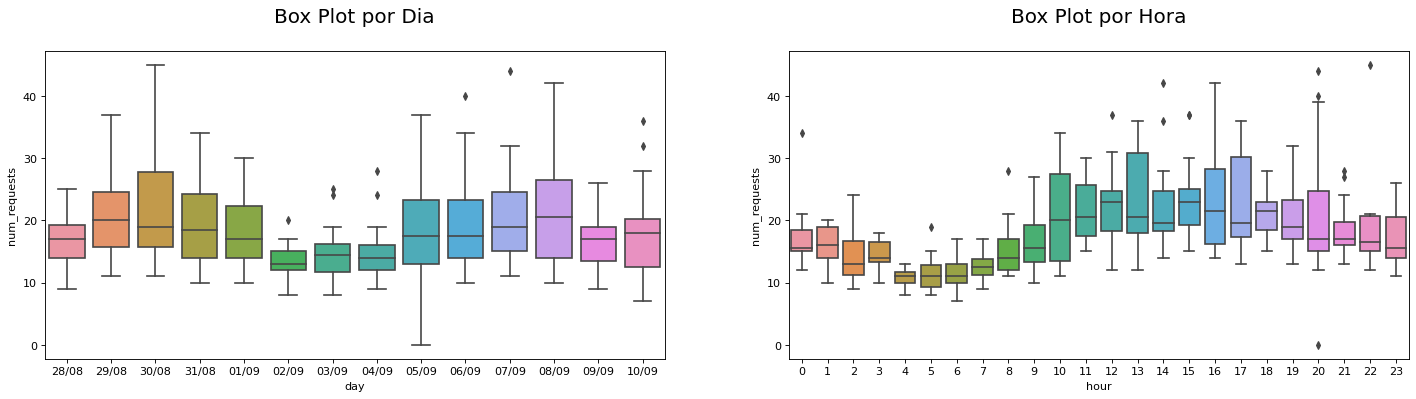

In [ ]:

# Prepare data
max_requests_hour['hour'] = [d.hour for d in max_requests_hour.index]
max_requests_hour['day'] = [d.strftime('%d/%m') for d in max_requests_hour.index]

# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(22,5), dpi= 80)
sns.boxplot(x='day', y='num_requests', data=max_requests_hour, ax=axes[0])
sns.boxplot(x='hour', y='num_requests', data=max_requests_hour)

# Set Title
axes[0].set_title('Box Plot por Dia\n', fontsize=18);
axes[1].set_title('Box Plot por Hora\n', fontsize=18)
plt.show()

A Análise visual dos gráficos box plot mostra uma quantidade maior de requisições no servidor nos dias de semana e quantidade menor nos finais de semana. O horário de 10 as 17h mostra um aumento nas requisições no gráfico diário.

#### Decomposição da série temporal

Como foi considerada a série temporal contendo o valor máximo de requisições por segundo em uma hora, foi selecionado o período de 24 horas (um dia) para a decomposição.
Obs.: Comportamento da decomposição foi o mesmo caso não seja informado o parâmetro de periodo (se o parâmetro period não for especificado na função seasonal_decompose, o valor padrão é None. Nesse caso, o algoritmo tentará detectar automaticamente o período sazonal com base nos dados fornecidos)

##### Por Segundo

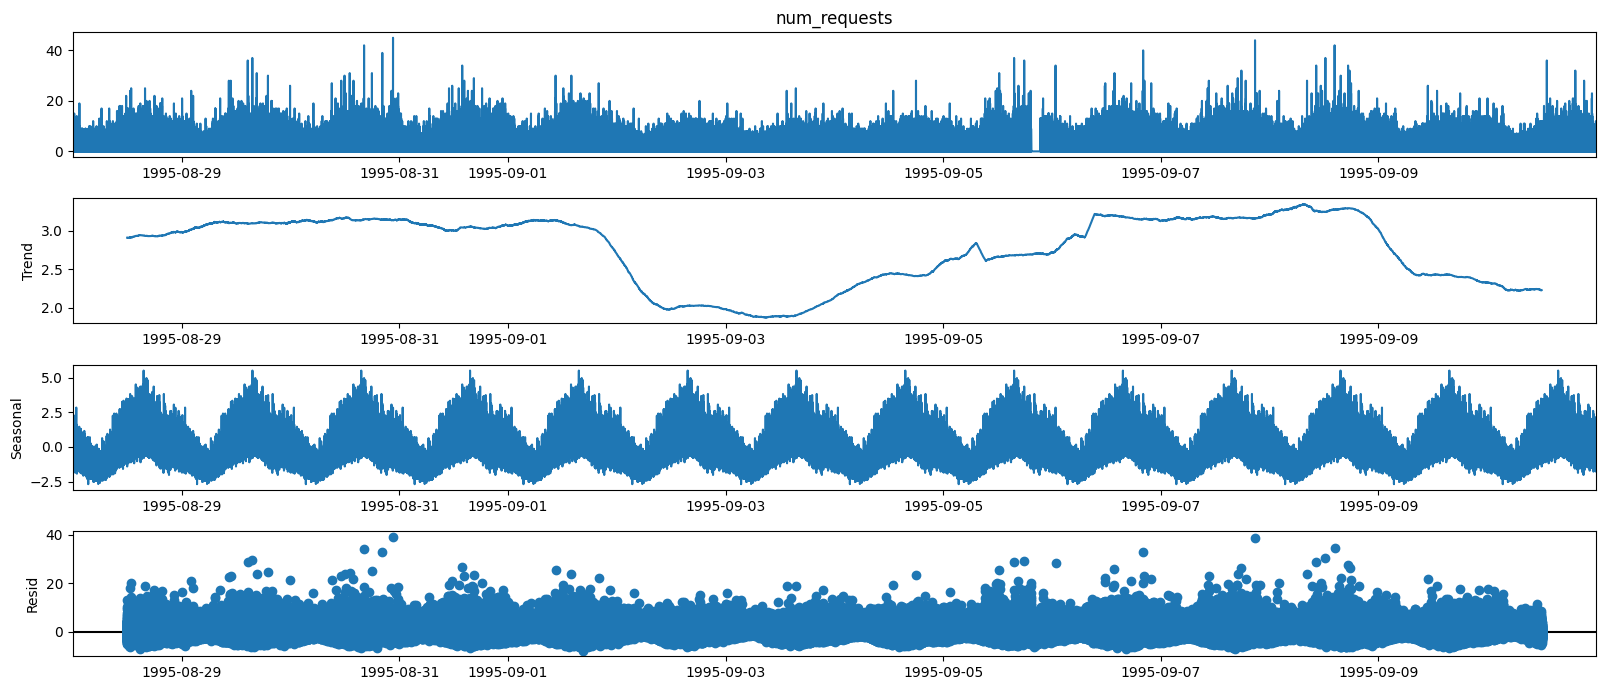

In [ ]:
res = seasonal_decompose(df_req_count['num_requests'], model='additive', period=24*60*60)
ax=res.plot()
ax.set_size_inches((16, 7))
ax.tight_layout()
plt.show()


##### Por minuto

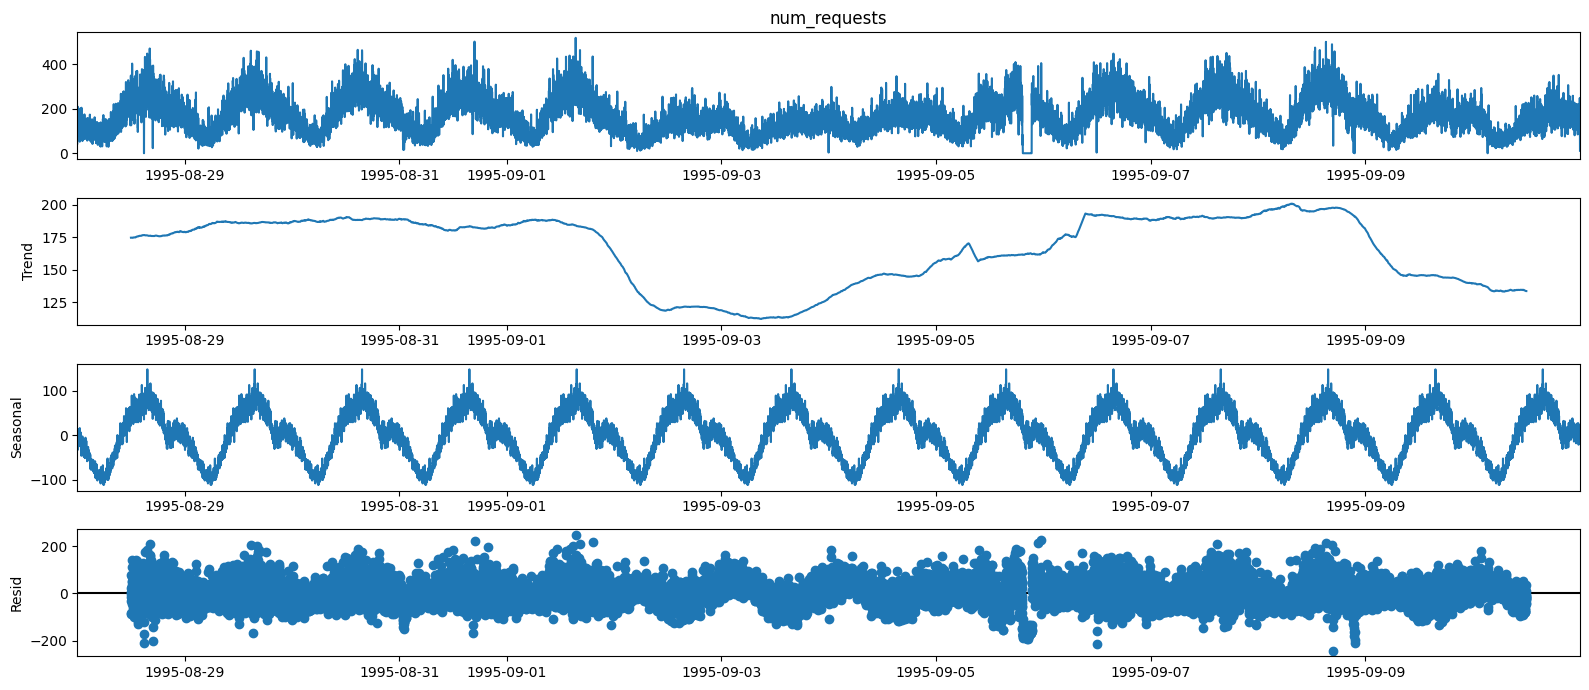

In [ ]:
res = seasonal_decompose(max_requests_min['num_requests'], model='additive', period=24*60)
ax=res.plot()
ax.set_size_inches((16, 7))
ax.tight_layout()
plt.show()

##### Por 10 min

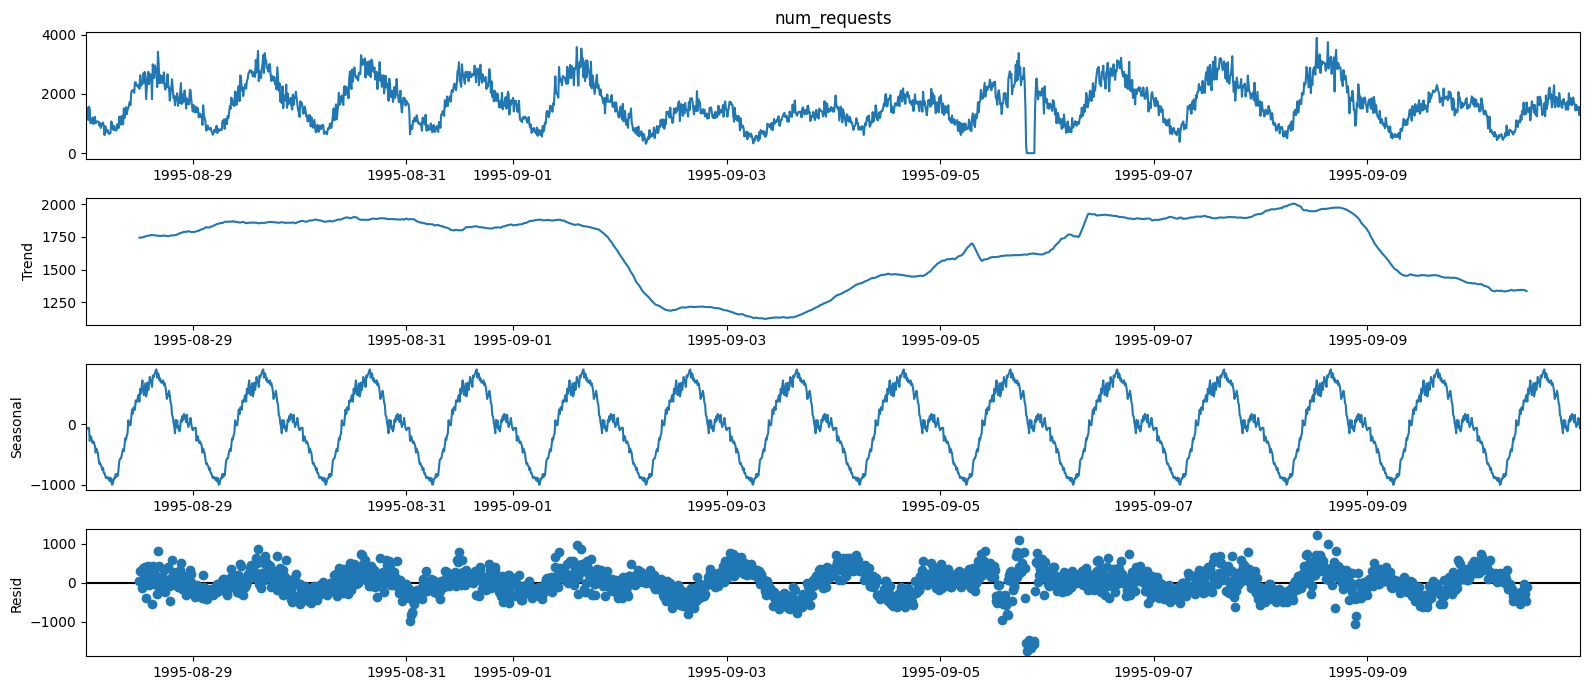

In [ ]:
res = seasonal_decompose(max_requests_10min['num_requests'], model='additive', period=24*6)
ax=res.plot()
ax.set_size_inches((16, 7))
ax.tight_layout()
plt.show()

##### Por hora

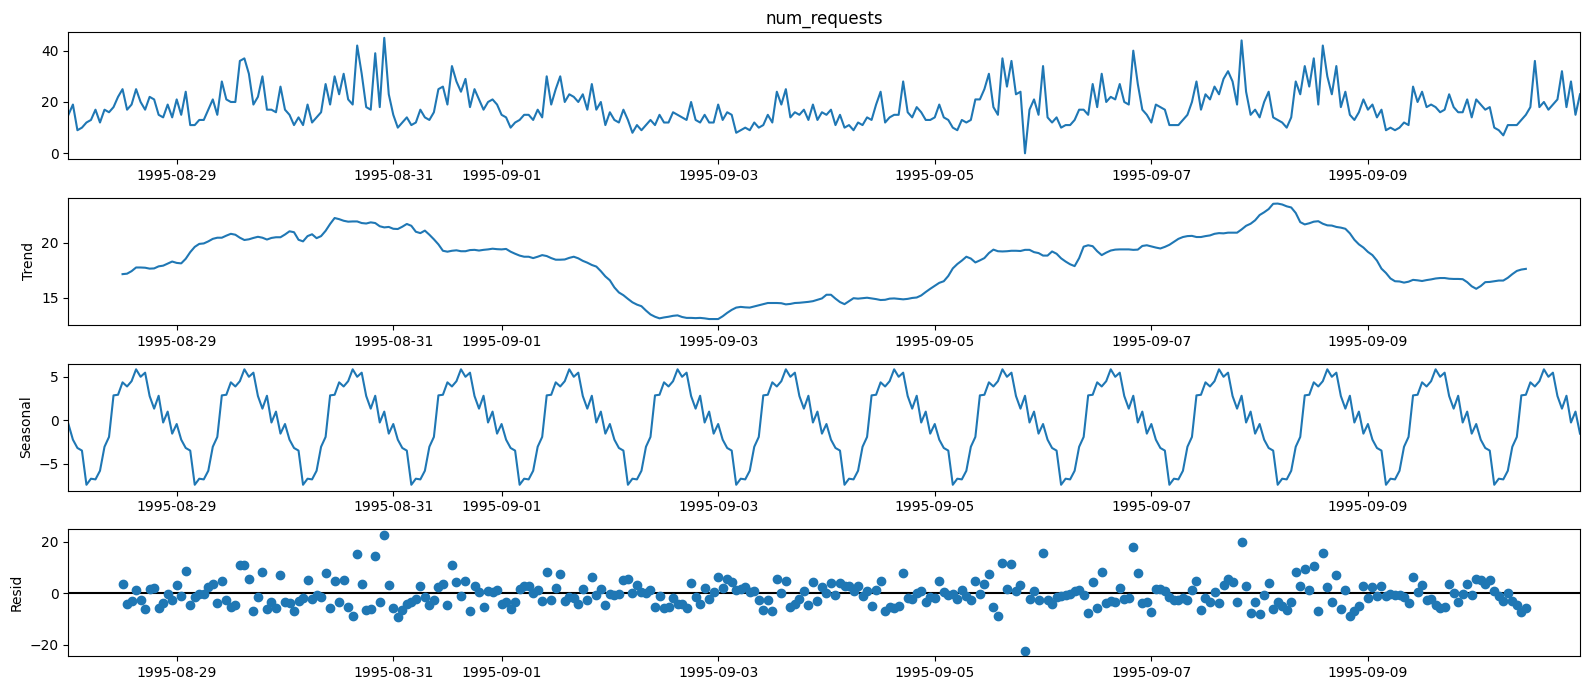

In [ ]:
res = seasonal_decompose(max_requests_hour['num_requests'], model='additive', period=24)
ax=res.plot()
ax.set_size_inches((16, 7))
ax.tight_layout()
plt.show()

#### Sazonalidade

Se a série possuir uma sazonalidade, é esperado que haja um padrão repetitivo nas autocorrelações em lags múltiplos do período da sazonalidade. Isso significa que a autocorrelação deve ser alta em lags múltiplos do período e baixa em outros lags.
Considerada para esta análise a serie que considera o valor máximo ocorrido no intervalo de uma hora.

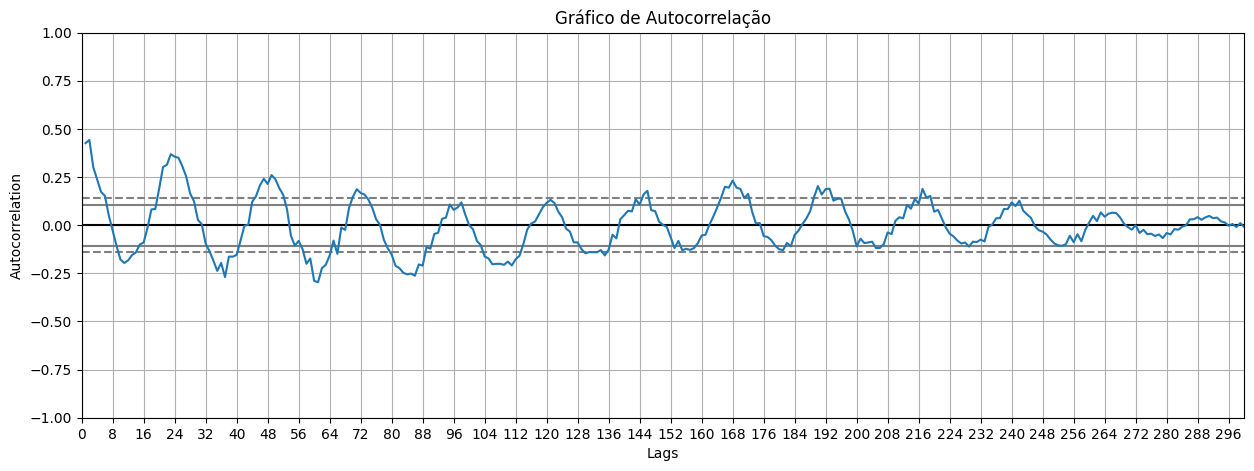

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
autocorrelation_plot(max_requests_hour.num_requests.tolist())

# Ajustar as faixas de lags no eixo x
ax.set_xlim(0, 300)  # Definir os limites do eixo x
ax.set_xticks(np.arange(0, 300, 8))  # Definir os valores dos ticks no eixo x
ax.set_xlabel('Lags')
ax.set_ylabel('Autocorrelation')
ax.set_title('Gráfico de Autocorrelação')

plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.title('Gráfico de Autocorrelação')
plt.show()



Picos fora da faixa de confiança nos lags 24 (diário), 48, 72 e 168 (semanal) são mais significativos indicando correlação e sazonalidade nesses períodos.

#### Testando a Estacionaridade

Em termos matemáticos, uma série temporal é estacionária quando suas propriedades estatísticas são independentes do tempo: Média, variância e covariância.

#### ADF
O teste de Dickey-Fuller aumentado (ADF) é um teste de hipótese que avalia a estacionariedade de uma série temporal.
O resultado do teste ADF inclui a estatística do teste ADF, o valor-p e valores críticos para diferentes níveis de significância.
As hipóteses para o teste de Dickey-Fuller aumentado (ADF) são:

- Hipótese nula (H0): A série temporal não é estacionária porque existe uma raiz unitária (se p-valor > 0,05)
- Hipótese alternativa (H1): A série temporal é estacionária porque não há raiz unitária (se p-valor ≤ 0,05)

A série temporal é estacionária se pudermos rejeitar a hipótese nula do teste ADF:
Se o p-value ≤ 0,05
Se a estatística de teste for mais extrema que os valores críticos

#### KPSS
As hipóteses para o teste de Kwiatkowski-Phillips-Schmidt-Shin (KPSS) são:

- Hipótese nula (H0): A série temporal é estacionária porque não há raiz unitária (se o valor de p > 0,05)
- Hipótese alternativa (H1): A série temporal não é estacionária porque há uma raiz unitária (se o valor de p ≤ 0,05)

Quanto mais positiva a estatística, maior a probabilidade de rejeitarmos a hipótese nula (temos uma série temporal não estacionária).

A série temporal é estacionária se não rejeitarmos a hipótese nula do teste KPSS:
Se o valor p > 0,05
Se a estatística de teste for menos extrema que os valores críticos

Ref.:

- Dickey, D. A. and Fuller, W. A. (1979). Distribution of the estimates for autoregressive time series with a unit root. J. Am. Stat. Assoc. 74, 427–431.
- Kwiatkowski, D., Phillips, P. C., Schmidt, P., & Shin, Y. (1992). Testing the null hypothesis of stationarity against the alternative of a unit root: How sure are we that economic time series have a unit root?. Journal of econometrics, 54(1–3), 159–178.
- Leonie Monigatti. Stationarity in Time Series — A Comprehensive Guide. Disponível em: https://towardsdatascience.com/stationarity-in-time-series-a-comprehensive-guide-8beabe20d68
- Shay Palachy Affek. Stationarity in time series analysis. Disponível em: https://towardsdatascience.com/stationarity-in-time-series-analysis-90c94f27322




In [ ]:

def test_adf(df, column):
    # Teste de Dickey-Fuller Aumentado (ADF)
    result_adf = adfuller(df[column])

    # Imprimir o resultado do teste ADF
    print("Resultado do Teste ADF:")
    print(f"Estatística do teste: {result_adf[0]}")
    print(f"Valor-p: {result_adf[1]}")
    print("Valores críticos:")
    for key, value in result_adf[4].items():
        print(f"{key}: {value}")

def test_kpss(df, column):
    # Teste de Kwiatkowski-Phillips-Schmidt-Shin (KPSS)
    result_kpss = kpss(df[column])

    # Imprimir o resultado do teste KPSS
    print("\nResultado do Teste KPSS:")
    print(f"Estatística do teste: {result_kpss[0]}")
    print(f"Valor-p: {result_kpss[1]}")
    print("Valores críticos:")
    for key, value in result_kpss[3].items():
        print(f"{key}: {value}")

##### Estacionaridade da série com resolução de 1 hora

In [ ]:
# Testando a estacionaridade para o dataframe com período de 1 hora
test_adf(max_requests_hour, 'num_requests')
test_kpss(max_requests_hour, 'num_requests')

Resultado do Teste ADF:
Estatística do teste: -6.504430307263498
Valor-p: 1.14049268370626e-08
Valores críticos:
1%: -3.4505694423906546
5%: -2.8704469462727795
10%: -2.5715154495841017

Resultado do Teste KPSS:
Estatística do teste: 0.13643723500550936
Valor-p: 0.1
Valores críticos:
10%: 0.347
5%: 0.463
2.5%: 0.574
1%: 0.739


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Para o teste ADF valor-p (1.14049268370626e-08) é menor que 0,05 e a e estatística do teste (-6.504) é mais extrema que o valor crítico para todos os níveis de significância (1%, 5%, 10%), indicando que pode-se rejeitar a hipótese nula e concluir que a série é estacionária.

O teste KPSS o valor-p (0.1) é maior que 0,05 e a estatística do teste é menos extrema que os valores críticos indicando que a série é estacionária.


##### Estacionaridade da série com resolução de 1 minuto

In [ ]:
# Testando a estacionaridade para o dataframe com período de 1 min
test_adf(max_requests_min, 'num_requests')
test_kpss(max_requests_min, 'num_requests')

Resultado do Teste ADF:
Estatística do teste: -4.533768029311696
Valor-p: 0.00017078402809473275
Valores críticos:
1%: -3.4306750240735258
5%: -2.8616836492652498
10%: -2.5668464605704426

Resultado do Teste KPSS:
Estatística do teste: 0.383087736838992
Valor-p: 0.08444494101767586
Valores críticos:
10%: 0.347
5%: 0.463
2.5%: 0.574
1%: 0.739


Para o teste ADF valor-p (0.0001707) é menor que 0,05 e a e estatística do teste (-4.5337) é mais extrema que o valor crítico para todos os níveis de significância (1%, 5%, 10%), indicando que pode-se rejeitar a hipótese nula e concluir que a série é estacionária.

O teste KPSS o valor-p (0.0844457) é maior que 0,05 e a estatística do teste (0.38) é menos extrema que os valores críticos 1%, 2.5% e 5% Indicando que a série é estacionária.


##### Estacionaridade da série com resolução de 10 minutos

In [ ]:
# Testando a estacionaridade para o dataframe com período de 10 min
test_adf(max_requests_10min, 'num_requests')
test_kpss(max_requests_10min, 'num_requests')

Resultado do Teste ADF:
Estatística do teste: -6.372641412674938
Valor-p: 2.3246631831926043e-08
Valores críticos:
1%: -3.4336386745240652
5%: -2.8629927557359443
10%: -2.5675433856598793

Resultado do Teste KPSS:
Estatística do teste: 0.13832389770604636
Valor-p: 0.1
Valores críticos:
10%: 0.347
5%: 0.463
2.5%: 0.574
1%: 0.739


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Para o teste ADF valor-p (2.3243138446077146e-08) é menor que 0,05 e a e estatística do teste (-6.3726) é mais extrema que o valor crítico para todos os níveis de significância (1%, 5%, 10%), indicando que pode-se rejeitar a hipótese nula e concluir que a série é estacionária.

O teste KPSS o valor-p (0.1) é maior que 0,05 e a estatística do teste (0.13) é menos extrema que os valores críticos 1%, 2.5% e 5% Indicando que a série é estacionária.

##### Estacionaridade da série com resolução de 1 segundo

In [ ]:
# O teste utiliza bastante recurso, gerando erro ao alocar a memória
#test_adf(df_req_count, 'num_requests')
#test_kpss(df_req_count, 'num_requests')

#### Autocorrelação

Plotando o gráfico de função de autocorrelação (ACF)
Quando há um forte padrão sazonal, o gráfico ACF geralmente revela picos repetidos definitivos nos múltiplos da janela sazonal.

A autocorrelação é simplesmente a correlação de uma série com suas próprias defasagens. Se uma série é significativamente autocorrelacionada, isso significa que os valores anteriores da série (lags) podem ser úteis para prever o valor atual.

A autocorrelação parcial também transmite informações semelhantes, mas transmite a correlação pura de uma série e seu atraso, excluindo as contribuições de correlação dos atrasos intermediários.

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


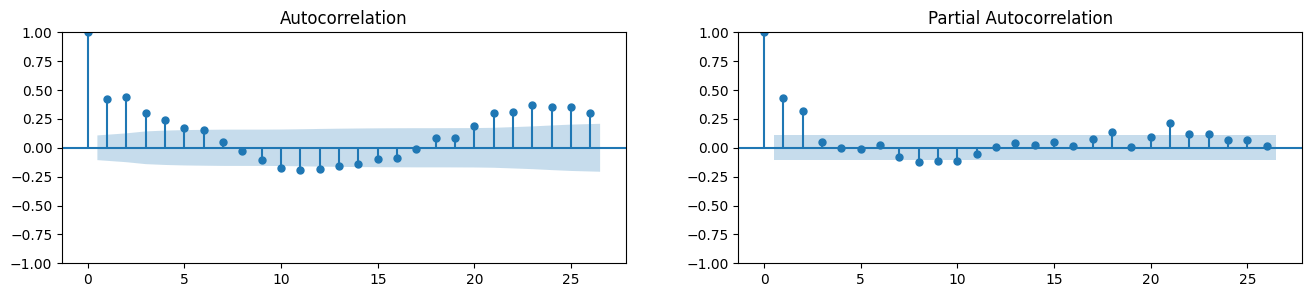

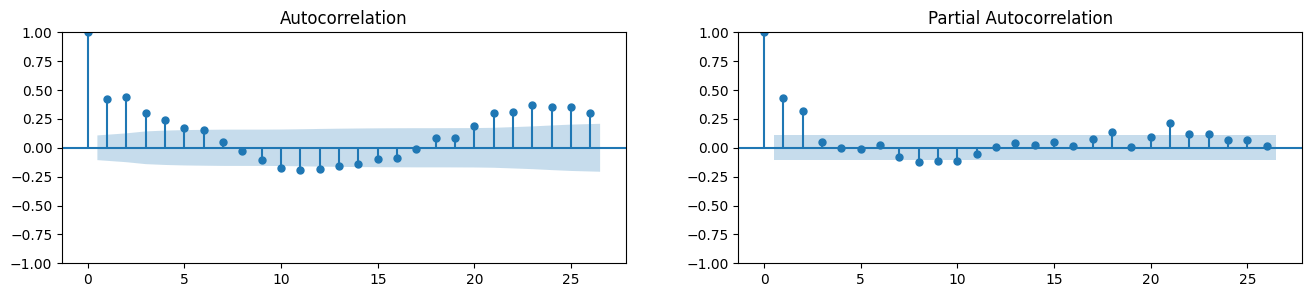

In [ ]:
# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(max_requests_hour.num_requests, ax=axes[0])
plot_pacf(max_requests_hour.num_requests, ax=axes[1])

- Os  que ultrapassam essa faixa indicam que a autocorrelação é estatisticamente significativa e não é apenas devido ao acaso. Esses valores podem indicar dependências temporais relevantes

### Gráfico de Atraso
Um gráfico Lag é um gráfico de dispersão de uma série temporal contra um atraso de si mesmo. Normalmente é usado para verificar a autocorrelação. Se houver algum padrão existente na série, como neste caso, a série é autocorrelacionada. Se não houver tal padrão, a série provavelmente será um ruído branco aleatório.

Há pouca dispersão à medida que o n_lag aumenta, ou seja, há um padrão na serie.

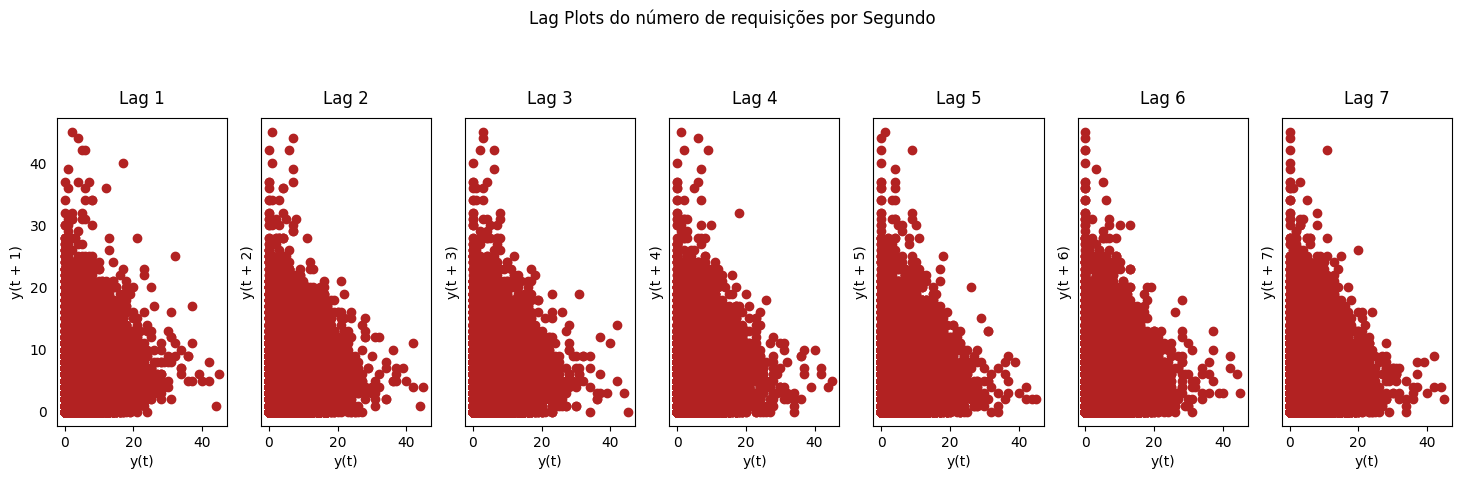

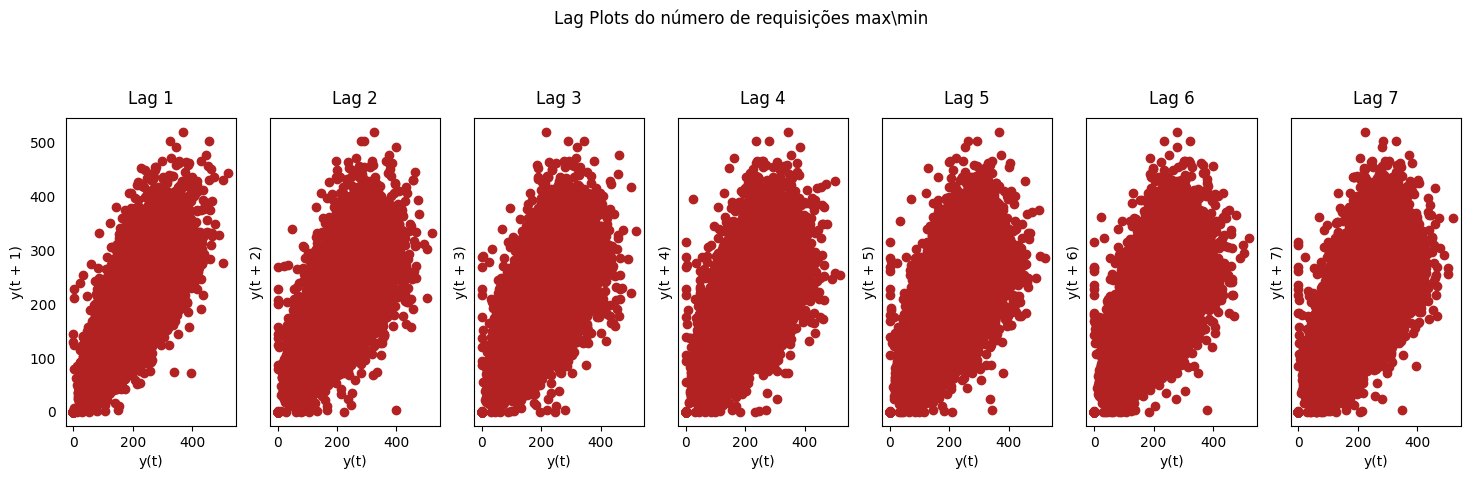

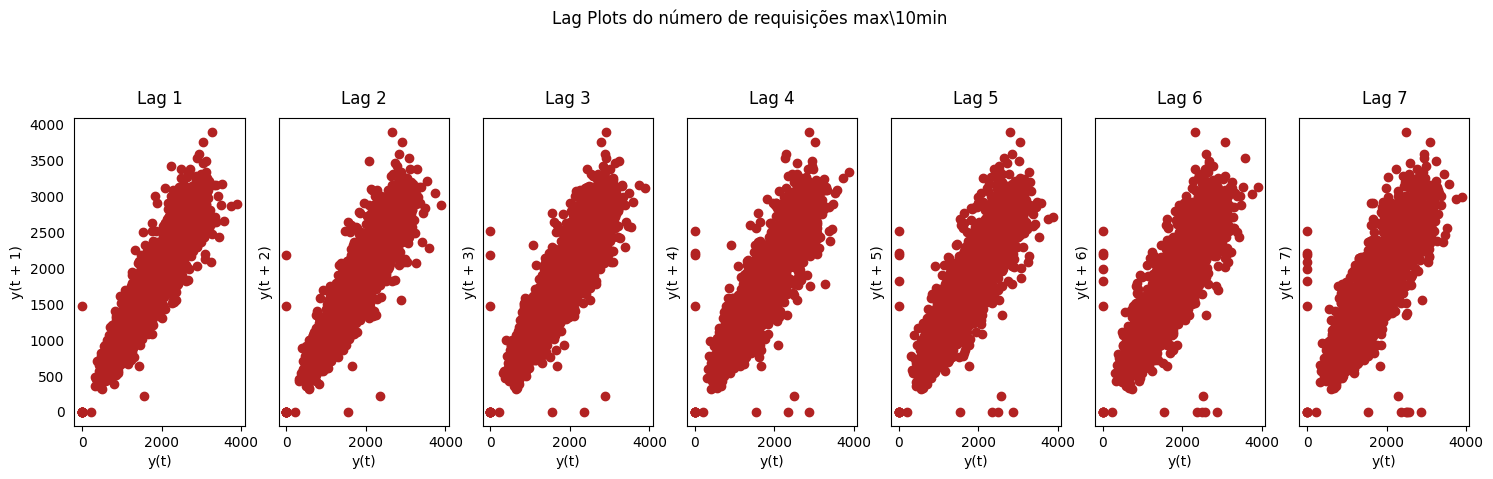

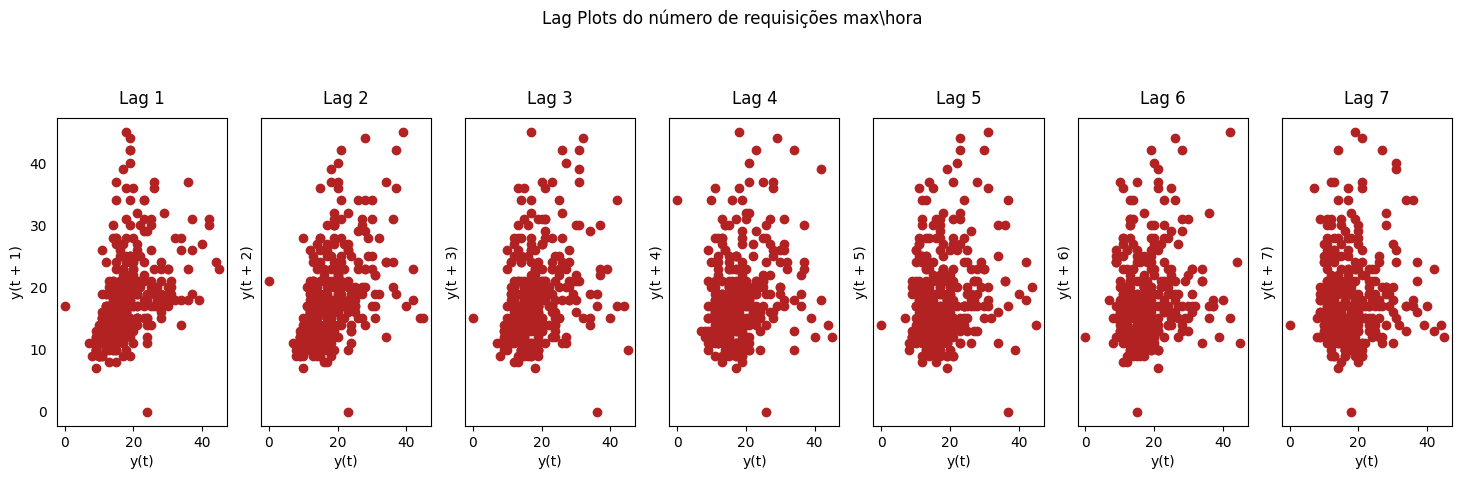

In [ ]:
def plot_lag_plots(df, num_plots=4, desc='Lag Plots do número de requisições\n'):
    """
    Plota os Lag Plots para uma série de dados.

    Parâmetros:
    - data: pandas Series, numpy array ou lista, contendo a série de dados
    - num_plots: int, número de Lag Plots a serem exibidos (padrão: 4)
    """

    plt.rcParams.update({'ytick.left' : False, 'axes.titlepad': 10})

    # Plot
    fig, axes = plt.subplots(1, num_plots, figsize=(18, 4), sharex=True, sharey=True, dpi=100)
    for i, ax in enumerate(axes.flatten()[:num_plots]):
        lag_plot(df, lag=i+1, ax=ax, c='firebrick')
        ax.set_title('Lag ' + str(i+1))

    fig.suptitle(desc, y=1.15)
    plt.show()

plot_lag_plots(df_req_count.num_requests, 7,'Lag Plots do número de requisições por Segundo\n')
plot_lag_plots(max_requests_min.num_requests, 7, 'Lag Plots do número de requisições max\min\n')
plot_lag_plots(max_requests_10min.num_requests, 7, 'Lag Plots do número de requisições max\\10min\n')
plot_lag_plots(max_requests_hour.num_requests, 7, 'Lag Plots do número de requisições max\hora\n')

### Estimando a presivibilidade da série temporal
Sample entropy

O resultado do cálculo de Sample Entropy indica a complexidade ou regularidade da série temporal de entrada. Valores mais baixos indicam maior regularidade, enquanto valores mais altos indicam maior complexidade.



In [ ]:
def SampEn(U, m, r):
    """Compute Sample entropy"""
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for j in range(len(x)) if i != j and _maxdist(x[i], x[j]) <= r]) for i in range(len(x))]
        return sum(C)

    N = len(U)
    return -np.log(_phi(m+1) / _phi(m))

# O calculo para a serie original em segundos demora muito, então foi comentado
#print("Sample entropy da serie /seg ", SampEn(df_req_count.num_requests, m=2, r=0.2*np.std(df_req_count.num_requests)))
print("Sample entropy /min ", SampEn(max_requests_min.num_requests, m=2, r=0.2*np.std(max_requests_min.num_requests)))
print("Sample entropy /10min", SampEn(max_requests_10min.num_requests, m=2, r=0.2*np.std(max_requests_10min.num_requests)))
print("Sample entropy /hora", SampEn(max_requests_hour.num_requests, m=2, r=0.2*np.std(max_requests_hour.num_requests)))


Sample entropy /min  1.4355342902353845
Sample entropy /10min 1.0178964040945822
Sample entropy /hora 1.543111709194064


Os valores obtidos de sample entropy:
 - /min:  1.4355683462011103
 - /10min: 1.0144605088683628
 - /hora: 1.543111709194064

 indicam que a série temporal possui uma complexidade intermediária nem totalmente regular nem totalmente aleatória e a serie /10min demonstrou ser a menos complexa das analisadas

#### Algoritmo de Machine Learning LSTM

O modelo LSTM (Long Short-Term Memory) é um tipo de rede neural recorrente que se destaca por sua habilidade de aprender dependências de longo prazo em sequências de dados. O funcionamento do modelo é baseado em células de memória que armazenam informações e as atualizam de acordo com os dados de entrada e as decisões tomadas pelo próprio modelo.

Cada célula de memória é composta por três portões (gates) que controlam o fluxo de informação: o portão de entrada (input gate), o portão de esquecimento (forget gate) e o portão de saída (output gate).

O portão de entrada decide qual a informação que será adicionada à célula de memória, com base na entrada atual e na informação armazenada anteriormente. O portão de esquecimento decide qual a informação deve ser descartada da célula de memória, permitindo que o modelo esqueça informações desnecessárias e mantenha apenas as informações mais relevantes. E o portão de saída decide qual a informação será usada como saída do modelo.

Esses portões são controlados por redes neurais densas que aprendem a partir dos dados de entrada e da saída desejada, ajustando seus pesos durante o treinamento da rede. Com isso, o modelo é capaz de aprender a detectar padrões em sequências de dados e fazer previsões com base nessas informações.



#### Motivação da escolha do algoritmo LSTM para o problema

O modelo LSTM tem sido amplamente utilizado em tarefas que envolvem sequências de dados, como previsão de séries temporais, reconhecimento de fala, processamento de linguagem natural, entre outros e sua aplicação vêm sendo utilizada no problema de escalonamento automático de recursos

O presente trabalho utilizará este algoritmo para previsão de carga de trabalho representada por uma serie temporal com o número de requisições por segundo realizadas em um servidor web.

## 3. Revisão Bibliográfica

### **Artigo 1**

#### Singh, P., Gupta, P. & Jyoti, K. TASM: technocrat ARIMA and SVR model for workload prediction of web applications in cloud (2018)

Artigo: [https://doi.org/10.1007/s10586-018-2868-6](https://doi.org/10.1007/s10586-018-2868-6).

O artigo propõe um modelo de predição adaptativo usando regressão linear, ARRIMA e Regressão de vetor de suporte SVR para aplicações web e utiliza a mesma base de dados (Clarknet)
O pré-processamento considerou o número de solicitações por 10 min.



### **Artigo 2**

#### Krishan Kumar, K. Gangadhara Rao, Suneetha Bulla, D Venkateswarulu. Forecasting of Cloud Computing Services Workload using Machine Learning (2021)
Artigo: [https://www.turcomat.org/index.php/turkbilmat/article/view/6660](https://www.turcomat.org/index.php/turkbilmat/article/view/6660).

O artigo compara modelos de predição usando machine learning. Utiliza a mesma base de dados (Clarknet) e o pré-processamento considerou o número de solicitações por 10 min



### **Artigo 3**

#### Parminder Singh, Avinash Kaur, Pooja Gupta, Sukhpal Singh, Gill Kiran Jyoti. RHAS: Robust Hybrid Auto-Scaling for Web Applications in Cloud Computing (2020)

Artigo: [https://doi.org/10.1007/s10586-020-03148-5](https://doi.org/10.1007/s10586-020-03148-5).

Neste artigo, foi proposto um Robust Hybrid Auto-Scaler (RHAS) para aplicações web. O modelo de previsão de série temporal foi usado para prever a carga de trabalho de entrada futura. Utiliza a mesma base de dados (Clarknet) e o pré-processamento considerou o número de solicitações por 1 min


### **Artigo 4**

#### Valter Rogério Messias, Julio Cezar Estrella, Ricardo Ehlers, Marcos José Santana, Regina Carlucci Santana, Stephan Reiff-Marganiec. Combining Time Series Prediction Models Using Genetic Algorithm to Auto-scaling Web Applications Hosted in the Cloud Infrastructure (2016)

Artigo: [https://doi.org/10.1007/s00521-015-2133-3 ](https://doi.org/10.1007/s00521-015-2133-3).

Neste artigo, foi proposto um método de previsão adaptativa usando algoritmos genéticos para combinar modelos de previsão de séries temporais. Utiliza a mesma base de dados (Clarknet) e o pré-processamento considerou o número de solicitações por 1 segundo.


### Resultados

<style>
r { color: Red }
o { color: Orange }
g { color: Green }
b { color: Blue }
</style>


Verificar notebooks python 0?-Artigo-Keras*

#### Serie por segundo (comparativo com o artigo 4)
##### Resultados obtidos no notebook python 02-Artigo-keras-sec.ipynb

| Requisições em 1 seg.      |
|----------------------------|

| Forecast Model | RMSE  |  
|----------------|-------|
| NAIVE          | 7.41  |  
| AR(1)          | 6.44  |
| ARMA(1, 1)     | 6.16  |   
| ARIMA          | 6.33  |   
| ETS            | 6.24  |
| GA             | 6.17  |
| <g>LSTM</g>    | **2.29**  |  

#### Serie por minuto (comparativo com o artigo 3)

| Requisições em 1 min.    |
|--------------------------|

| Prediction model | RMSE  |
|------------------|-------|
| LR               | 64.37 |
| SVR              | 64.67 |  
| AR               | 54.60 |  
| MA               | 59.24 |   
| ARMA             | 59.25 |  
| ARIMA            | 51.24 |  
| TASM             | 42.24 |
| <g>LSTM</g>      | **40.87** |    

#### Serie por 10 minutos (comparativo com os artigos 1 e 2)

**Artigo 2**

| Requisições em 10 min.   |          
|--------------------------|

| Models | RMSE   |   
|--------|--------|
| KNN    | 250.81 |   
| LR     | 295.14 |   
| SVM    | 320.15 |   
| ARMA   | 250.45 |
| ARIMA  | 235.72 |
| <g>LSTM</g> | **235.26** |    


**Artigo 1**

| Requisições em 10 min.   |
|--------------------------|

| Models | RMSE   |   
|--------|--------|
| Naıve  | 256.04 |
| LR     | 282.08 |  
| AR     | 240.54 |   
| MA     | 263.21 |
| ARMA   | 286.14 |  
| ARIMA  | 241.69 |
| SVR    | 304.99 |  
| <g>TASM</g>   | 214.26 |
| <o>LSTM</o>      | **235.88** |      

#### Comparativo com auto-ml


| Requisições em 10 min.   |
|--------------------------|

|   Models     | RMSE         |
|--------------|--------------|
| (auto-ml)ML |   350.101366 |
| (auto-ml)auto_SARIMAX |   801.851493 |
| (auto-ml)Prophet | 84837.970566 |  
| <g>LSTM</g>      | **235.88** |    


#### Serie gerada a partir do valor máximo de requisições por segundo no intervalo de 1h
##### Obs.:Abordagem que será avaliada no trabalho futuro de implementação do escalonador

| Max Requisições por hora |
|--------------------------|

| Models | RMSE   |   
|--------|--------|
| <g>Interpolation+LSTM</g> | **11.82** |  
